### Getting Started

1. Install alpaca package on the terminal through 


```
pip install alpaca-proteomics
```


2. Import the package


In [1]:
from alpaca_proteomics import alpaca

## Data import and formatting

Alpaca works with unprocessed proteomics datasets from MaxQuant. The package takes the file `proteinGroups.txt`, which can be found in the combined folder of MaxQuant output. This dataset is from the exoproteome data published in [Ferrero-Bordera et al. 2024. Microbiology Spectrum](https://doi.org/10.1128/spectrum.02616-23).

In [2]:
file = 'proteinGroups.txt'

# Data importation
df, id_col, it = alpaca.eats('proteinGroups.txt')

The column Protein IDs was detected to contain your ProteinGroups IDs.
The following intensity methods were detected in the data: Intensity, iBAQ, LFQ


The function returned:

- **df** is the imported data as a pandas dataframe
- **id_col** corresponds to the column which was detected to contain the Protein IDs
- **it** is a dictionary which groups the columns containing intensity data within each intensity method (e.g. LFQ)

In our example, the data contained 3 intensity methods (Intensity, iBAQ, LFQ)

### Assistance on the analysis (Optional)

In [3]:
standards_file = 'UPS2.xlsx' # Path to the anchor proteins file
st_proteins = alpaca.eats(standards_file) # Importation of the anchor proteins file (more details on these are listed below)
spiked_samples = ['Before_Induction_01', 'Control_01', 'Diamide_01'] # Samples in which anchor proteins were added
values_per_sample = 1/4 # Valid values per condition

suggested = alpaca.Consultant(df,
                         st_proteins,
                         it, 
                         added_samples=spiked_samples,
                         values_per_sample=values_per_sample)

Based on your data, Median-normalized iBAQ is recommended for the quantification.


The function returns an suggested analysis method and a dataframe with the calculated scores for each intensity method with different normalization approaches. These data is visualized below.

<Axes: xlabel='Intensity method', ylabel='Normalization'>

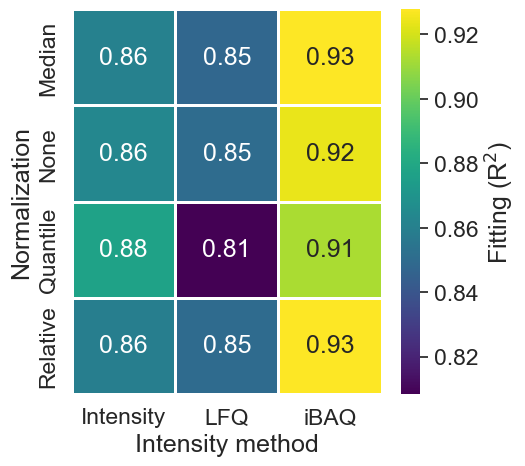

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(5,5))
sns.set(font_scale=1.5)
sns.heatmap(suggested.pivot(index='Normalization', columns='Intensity method', values='score'),
           annot=True, cmap='viridis', lw=1, cbar_kws={'label': 'Fitting (R$^2$)'})

### Data pre-processing

Based on the suggestions from the function alpaca.Consultant, the analysis can continue with the most suitable parameters.

In [5]:
# Data pre-processing

values_per_sample = 1/4

clean_df = alpaca.spits(df, 
                        lfq_method='iBAQ',
                        formatting=True, 
                        valid_values=values_per_sample,
                        normalization='Median',
                        info_cols=['Accession', 'Gene names'])
clean_df.head(5)

3 experimental conditions were identified in the data: Before_Induction, Control, Diamide
Items marked on Only identified by site, Reverse, Potential contaminant have been removed from the dataset.
Dataset formated for further analysis and visualisation.


,Accession,Protein,Sample,iBAQ,Condition,Replicate
3,C0SP82,YoaE,iBAQ Before_Induction_01,2.083660,Before_Induction,01
4,C0SP93,AccD,iBAQ Before_Induction_01,2.312376,Before_Induction,01
5,C0SP94,YhfQ,iBAQ Before_Induction_01,-2.030633,Before_Induction,01
6,C0SPA7,YukB,iBAQ Before_Induction_01,-8.627621,Before_Induction,01
7,C0SPB0,YtcI,iBAQ Before_Induction_01,0.498673,Before_Induction,01


## Anchor protein quantification

Absolute quantification using Alpaca is optimised for label-free methods, relying on the addition of a set of anchor proteins at a know amount. 

**Table 1.** Format for the file describing the stock solution of anchor proteins.

| Accession  | MW (kDa) | Amount (fmol) |
|------------|---------:|--------------:|
| P02768     |   10.1   |         50    |
| Q9Y6K9     |   65.8   |        100    |
| P05067     |   32.5   |         25    |
| O75475     |   48.2   |         75    |
| Q00653     |   20.9   |         30    |

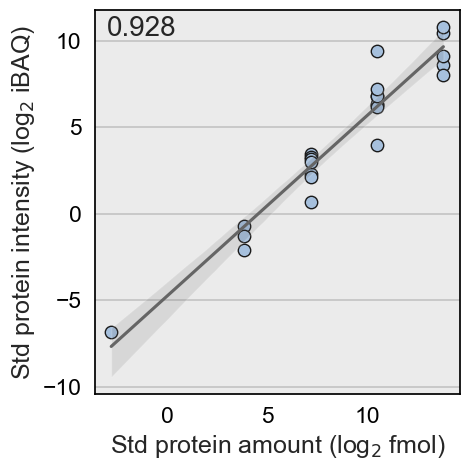

In [6]:
# Import the file containing the information about the quantification standards proteins

standards_file = 'UPS2.xlsx'
st_proteins = alpaca.eats(standards_file)

# If applicable, define which samples/replicates contain standards proteins

spiked_samples = ['iBAQ Before_Induction_01', 'iBAQ Control_01', 'iBAQ Diamide_01']

# Quantify the fmol present in the measured samples

quant_df, st_proteins, coef, inter, r2 = alpaca.census(clean_df, st_proteins, lfq_col='iBAQ',
                                                      filter_col = 'Sample', # Defines which column to filter for the spiked samples
                                                      added_samples = spiked_samples) # Adding which samples contain the standars

`alpaca.census()` adds a column to the processed data with the calculated mol amounts present in the measured samples.

## Experimental details


In [7]:
sample_prep = pd.read_csv('params.csv', sep=',')
sample_prep.sample()

,Condition,SampleVolume,ProteinConcentration,AmountMS,CellsPerML,TotalCultureVolume,ProteinSRM,fmolSRM,Enrichment,EnrichmentMode,StdDilution,StdVolume
1,Control,9.310715,7.766196,1.060855,1.658673,9.223972,P54576,6.914357,True,Sampling,9.943855,9.530689


Experimental details (in our example `params.txt`) can be added as txt, csv or xlsx formats. This file can include the columns described in the following table:

**Table 2.** Experimental parameters table. This example covers all possible columns. Nonetheless, not all columns are necessary. For example, Enrichment columns (EnrichmentMode, StdDilution, StdVolume) are only used if any enrichment step was performed. More information about this is described in the Enrichment section.

| Condition   | SampleVolume | ProteinConcentration | AmountMS | CellsPerML | TotalCultureVolume | ProteinSRM | fmolSRM | Enrichment | EnrichmentMode | StdDilution | StdVolume |
|-------------|--------------|----------------------|----------|------------|--------------------|------------|---------|------------|---------------------|-------------|-----------|
| Cond1_t0    | 2.31         | 2.99                 | 9.67     | 4.54       | 7.54               | TNAMLN     | 4.44    | False      |                 | 3.96        | 1.22      |
| Cond2_t1    | 2.50         | 0.20                 | 4.10     | 5.13       | 2.62               | AJFVYC     | 4.85    | True       | Sampling                | 2.43        | 1.51      |
| Cond3_t2    | 7.38         | 6.56                 | 2.77     | 3.66       | 3.80               | BYEKSC     | 9.71    | True       | Amplification                | 5.71        | 8.53      |

## Proteome fraction enrichment (Optional)

In case the study focuses in a fraction of the proteome (e.g., membrane proteome or exoproteome), it is likely that during the sample preparation and enrichment step was performed. This module allows to translate the enrichment step to the data based on how the samples were prepared. 

`Enrichment factors` are calculated based on the fmol quantified in the enriched sample to the raw or non-enriched sample:

$$
ER = \frac{fmol_{enriched}}{fmol_{non-enriched}}
$$

For that purpose, there are 2 strategies that are currently covered under our pipeline:

**1. The quantification of specific proteins of the analysed fraction on both before and after the enrichment step using Targeted MS (SRM).** 

This strategy was described on [Antelo-Varela et al. 2019](https://pubmed.ncbi.nlm.nih.gov/31424929/) and relies on using external protocols (e.g., Skyline) to quantify the enrichment step. Enrichment factors can be added to the parameters table under the column `Enrichment_Factor`. Additionally, the SRM quantified amount for a given protein can be added on the columns `ProteinSRM` (Accession of the quantified protein) and `fmolSRM` (Quantified fmol in the analysed proteome fraction).

**2. The addition of whole proteins at known concentration before performing the enrichment step.**

This approach was described on [Ferrero-Bordera et al. 2024](https://doi.org/10.1128/spectrum.02616-23) and requires of a protein mixture at known concentration added before the enrichment step. Used standards have to be formatted as specified in the table below:

**Table 3.** Enrichment standards

| Accession | MW (kDa) | StdConcentration (µg/µl) |
|-----------|---------:|-------------------------:|
| P02768    |     10.1 |                     2.5  |
| Q9Y6K9    |     65.8 |                     0.8  |
| P05067    |     32.5 |                     1.2  |
| O75475    |     48.2 |                     3.0  |
| Q00653    |     20.9 |                     2.0  |


In [8]:
# Enrichment Standard importation

enrichment_std = pd.read_excel('enrichment_std.xlsx')
enrichment_std.sample(3)

,Protein,Accession,Chain length,MW (kDa),StdConcentration
4,Lisozyme,P00698,129 aa,14.3,17.780320
2,ADH,P00330,348 aa,36.8,45.756347
3,Soybean Trypsin Inhibitor,P01071,181 aa,20.0,24.867580


In [9]:
enrichment_std, sample_prep_updated = alpaca.gathers(clean_df, enrichment_std, sample_prep)

Enrichment factor for condition Before_Induction: 17.97
Enrichment factor for condition Control: 34.65


## Data integration

This module connects the protein amounts quantified in the sample and the sample preparation. Thus, allowing to calculate protein amounts to the original state (e.g. bacterial culture, raw culture supernatant). This step brings deeper insights to the user based on the known experimental parameters, yielding high valuable data (e.g., molecules per cell, fmol / µmol of protein extract)

In [10]:
results = alpaca.wool(quant_df, sample_prep_updated)

results.sample(3)

,Accession,Protein,Sample,iBAQ,Condition,Replicate,fmol,Molecules,fmolSample,MoleculesPerCell
14063,P29252,FolK,iBAQ Diamide_03,-1.290911,Diamide,03,17.039546,5.304567e+10,88.071837,2.809453e+09
14186,P39120,CitZ,iBAQ Diamide_03,3.895811,Diamide,03,533.536478,1.660948e+12,2757.675511,8.796864e+10
6599,Q01464,MinD,iBAQ Control_01,-0.565776,Control,01,9.159222,3.760164e+11,624.300851,2.457695e+10
